In [41]:
# Para no tener que reiniciar el kernel
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import pickle

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product, combinations
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF

# Para imputar nulos
# -------------------------------------------------------------------------
from sklearn.experimental import enable_iterative_imputer  # Habilita IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Para tratar el problema de desbalance
# -----------------------------------------------------------------------
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder #, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

from category_encoders import TargetEncoder 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import sys
import os
sys.path.append(os.path.abspath('../'))

In [43]:
# Insertamos los soportes de nuestro src
from src import soporte_preprocesamiento as sp
from src import soporte_encoding as se
from src import soporte_logistica_preprocesamiento as slp
from src import soporte_outliers as so



In [44]:
# Instrucción para visualizar todas las columnas de un dataFrame
pd.set_option('display.max_columns', None)

In [45]:
df_scaled=pd.read_pickle("../datos/datos_scaled.pkl").reset_index(drop=True)


In [46]:
df_scaled.head()

,Attrition,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,DistanceFromHome,EducationField,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,JobInvolvement,Gender_Female,Gender_Male,Education_1.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,JobLevel_Head,JobLevel_Intern,JobLevel_Junior,JobLevel_Manager,JobLevel_Senior,StockOptionLevel_Bad,StockOptionLevel_Best,StockOptionLevel_Better,StockOptionLevel_Good
0,0.0,0.000000,-0.975743,1.000000,1.153846,0.000000,-1.0,-0.083333,0.533046,-0.463706,0.0,1.498811,-0.333333,-0.500000,-1.000000,-3.415572,-0.666667,-0.333333,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.000000,0.000000,1.424875,-0.384615,0.099529,0.0,0.250000,0.533046,0.523841,1.0,-0.133480,-0.666667,1.500000,-0.444444,0.102377,0.000000,0.000000,1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.765804,0.000000,6.850501,-0.307692,0.099529,0.0,0.833333,-4.206791,0.177356,0.0,2.634668,-0.333333,0.166667,-0.555556,0.000000,0.000000,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,-0.234196,-0.975743,0.000000,0.153846,-0.069569,0.0,-0.416667,0.533046,-0.745947,0.0,0.622052,0.333333,-0.500000,0.333333,-0.897623,0.500000,2.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,-0.234196,1.260038,0.000000,-0.307692,0.000000,0.0,0.250000,0.000000,0.177356,1.0,-0.471201,0.666667,-0.333333,-0.111111,0.000000,0.166667,-0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Nos quedamos para estudiar los outliers con las columnas que en nuestro EDA fueron consideradas numericas, (ahora, despues del Encoding todas lo son, pero para el estudio de outliers no nos interesan las que consideramos categóridas, pues no habiendo datos errones en el dataframe, en las categoricas no gestionamos valores atípicos).

In [47]:
df=pd.read_pickle("../datos/datos_sin_nulos.pkl").reset_index(drop=True)
df_num=df.select_dtypes(include=np.number)
df_num.columns

Index(['Age', 'Attrition', 'DistanceFromHome', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
       'YearsAtCompany', 'YearsSinceLastPromotion'],
      dtype='object')

In [48]:
df_outliers=df_scaled[['Age', 'Attrition', 'DistanceFromHome', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsSinceLastPromotion']]

In [49]:
type(df_outliers )

pandas.core.frame.DataFrame

Vamos a identificar los outliers univariados. Lo vemos gráfica y analíticamente.

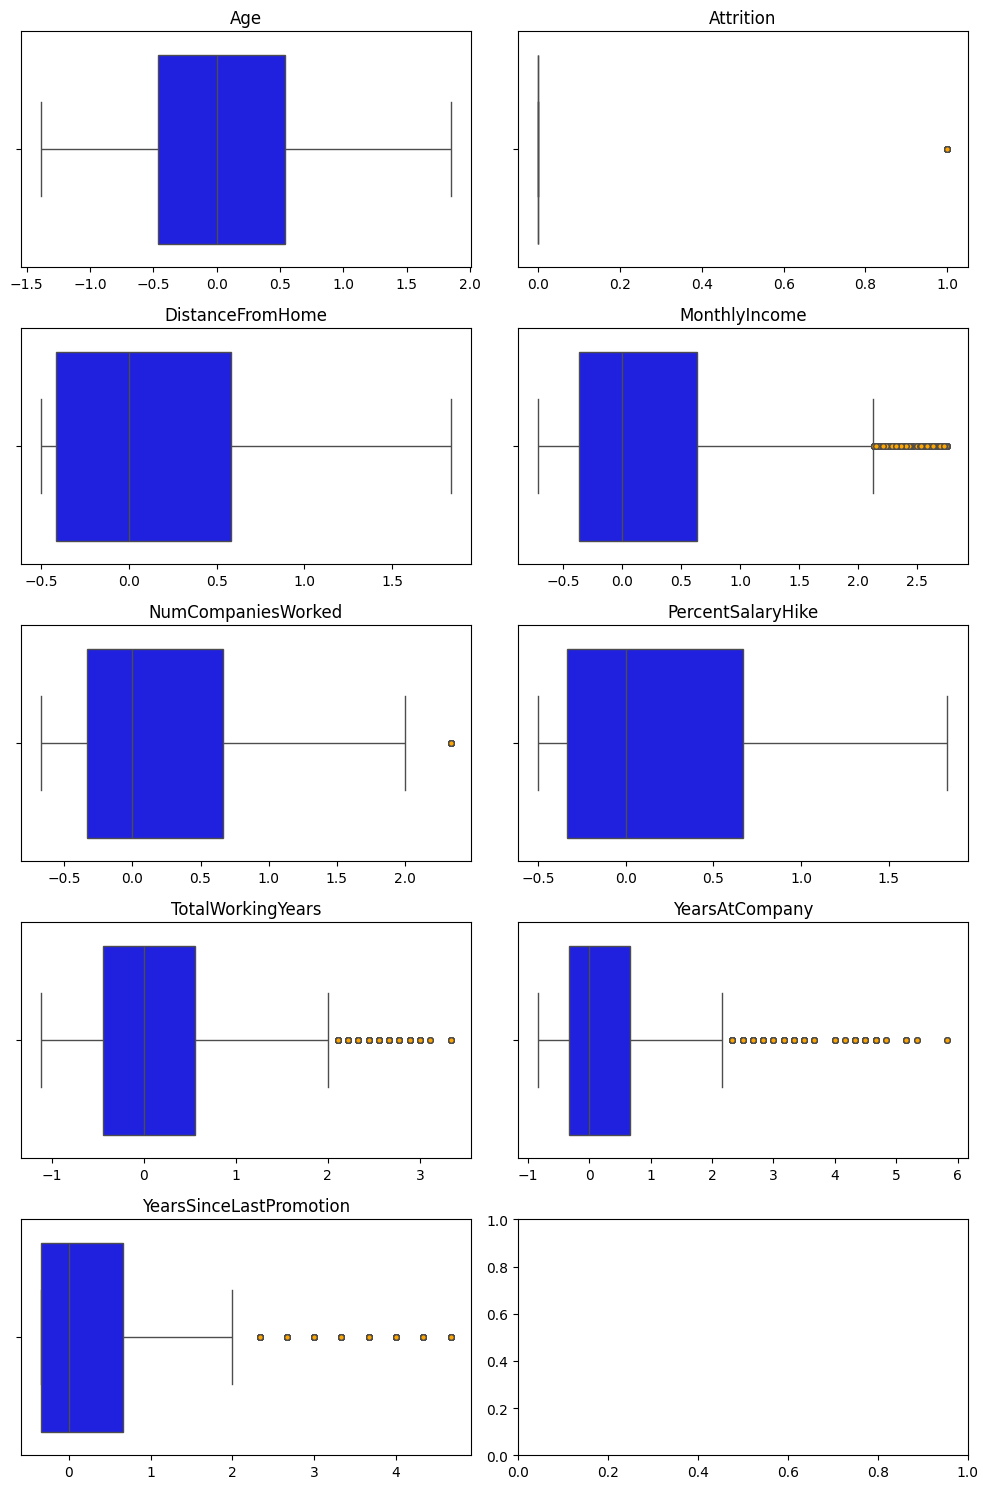

In [50]:
gestion = so.GestionOutliersUnivariados(df_outliers)

# llamamos al método que nos permite identificar outliers univariados de forma visual (boxplot)
gestion.visualizar_outliers_univariados()

Vamos a estudiar analíticamente cuántos outliers tenemos en cada columna

In [51]:
so.describe_outliers(df_outliers)

,columna,n_outliers,limite_inf,limite_sup,%_outliers
1,Attrition,711,0.000000,0.000000,16.12
3,MonthlyIncome,342,-1.867160,2.132840,7.76
8,YearsSinceLastPromotion,321,-1.833333,2.166667,7.28
7,YearsAtCompany,312,-1.833333,2.166667,7.07
6,TotalWorkingYears,189,-1.944444,2.055556,4.29
4,NumCompaniesWorked,156,-1.833333,2.166667,3.54
0,Age,0,-1.961538,2.038462,0.00
2,DistanceFromHome,0,-1.916667,2.083333,0.00
5,PercentSalaryHike,0,-1.833333,2.166667,0.00


Hay tres columnas con un numero importante de outliers, a parte de Attrition, que siendo la variable respuesta la dejaremos como está, MonthlyIncome, TotalWorkingYears y YearsAtCompany. No los vamos a eliminar, porque no tenemos evidencias de que sean datos erroneos, de hecho, es razonable que aquellos que tienen más experiencia laboral y/o llevan mmás años en la companía tengan un sueldo mensual más alto, así que es posible que esos datos sean lógicos y estén conectados entre sí. No obstante, esperaremos a estudiar los otuliers multivariados para tomar una decisión.